# 8章 マルコフ連鎖モンテカルロ法とベイズ統計モデル

GLMM(一般化線形混合モデル)では$r_i$に関して積分をして、尤度から$r_i$を消去していた。(p.156,$L_i=\int_{-\infty}^{\infty}p(y_i\mid\beta_1, \beta_2, r_i)p(r_i\mid s)dr_i$)  
個体差、場所差などランダム効果が増えると多重積分が必要になり、最尤推定値の探査が困難となる。そこで__MCMC法__

### この章の流れ  
とりあえず一変量の例題を用いて、  
1. 試行錯誤による最尤推定法(効率の悪い)    
2. MCMCアルゴリズムに改良(特にメトロポリス法)  
を行い、  
3. ベイズ統計モデルという考え方と定常分布の紹介  
を行う。

## 8.1 この章での例題

各植物個体8個の種子のうち、生き残った種子の数。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as scm
data = np.array([4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4])

一応生存確率0.45の二項分布として生成している。

(0, 7)

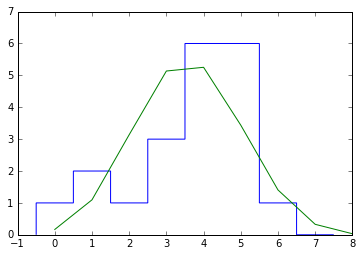

In [2]:
nmax = 8
p = 0.45
fig_in = plt.figure()
ax1 = fig_in.add_subplot(111)
ax1.hist(data,bins=nmax,range=(0,nmax),align='left',histtype='step')
x = np.arange(0,nmax+1)
y = scm.comb(nmax,x)*p**x*(1.0-p)**(nmax-x)*data.size
ax1.plot(x,y)
ax1.set_ylim(0,7)

最尤推定値は

In [3]:
sum(data)/(nmax*data.size)

0.45624999999999999

## 8.2 ふらふら試行錯誤による最尤推定値(効率が悪い方法)

ルール  
1. 適当な初期値$q_0$からスタート  
2. $q_n$をランダムに0.01増減させて$q_n'$を生成し、尤度$L(q_n')$を計算
3. $L(q_n)<L(q_n')$ と当てはまりが良くなれば$q_{n+1}=q_n'$, 逆なら$q_{n+1}=q_n'$とする

In [4]:
def furafura(ns,dq,q0,nmax,data): ## Step 数, 変化幅, 初期値, nmax, data
    from scipy.stats import binom
    nstep = np.arange(0,ns)
    q1 = np.zeros(nstep.size)
    q_old = q0
    logl_old = sum(binom.logpmf(data,nmax,q_old))
    for i in nstep:
        qtemp = q_old + np.random.choice([-1,1]) * dq
        logltemp = sum(binom.logpmf(data,nmax,qtemp))
        if(logltemp > logl_old):
            q1[i] = qtemp
            logl_old = logltemp
            q_old = qtemp
        else:
            q1[i] = q_old
    fig_f = plt.figure()
    ax_f = fig_f.add_subplot(111)
    ax_f.plot(nstep,q1)
    return q1[ns-1]

初期値が0.30の場合

0.46000000000000013

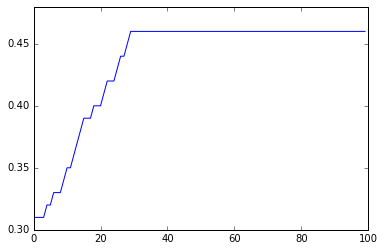

In [5]:
furafura(100,0.01,0.30,nmax,data)

実際にはRなどで実装されているものでは$q$は離散化されていないし、もっと少ないstep 数で到達できる。

## 8.3 MCMCアルゴリズムのひとつ: メトロポリス法

ふらふら試行錯誤にルールを加えて、  
1. 適当な初期値$q_0$からスタート  
2. $q_n$をランダムに0.01増減させて$q_n'$を生成し、尤度$L(q_n')$を計算
3. $L(q_n)<L(q_n')$ と当てはまりが良くなれば$q_{n+1}=q_n'$, 逆なら$q_{n+1}=q_n$とする  
4. **$L(q_n)>L(q_n')$と悪化した場合にも確率$L(q_n')/L(q_n)$で$q_{n+1}=q_n'$とする**


In [6]:
def metropolis(ns,dq,q0,nmax,data): ## Step 数, 変化幅, 初期値, nmax, data
    from scipy.stats import binom
    import seaborn as sns
    nstep = np.arange(0,ns)
    q1 = np.zeros(nstep.size)
    q_old = q0
    logl_old = sum(binom.logpmf(data,nmax,q_old))
    for i in nstep:
        qtemp = q_old + np.random.choice([-1,1]) * dq
        logltemp = sum(binom.logpmf(data,nmax,qtemp))
        cr = np.random.rand()
        p_trans = np.exp(logltemp - logl_old)
        if(cr < p_trans): 
        ## p_trans > 1 すなわち、logltemp が大きくなった場合には自動的に満たされる
            q1[i] = qtemp
            logl_old = logltemp
            q_old = qtemp
        else:
            q1[i] = q_old
    sns.jointplot(nstep,q1,xlim=(0,ns),ylim=(0.25,0.65))
    return q1

100回の場合、1000回の場合、10000回の場合

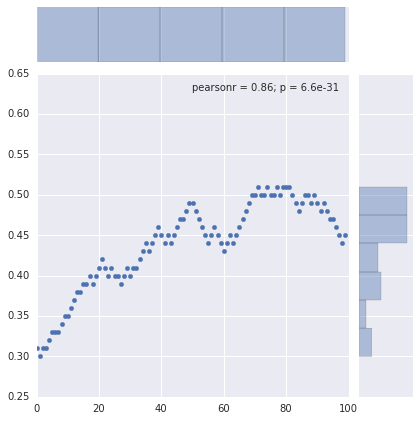

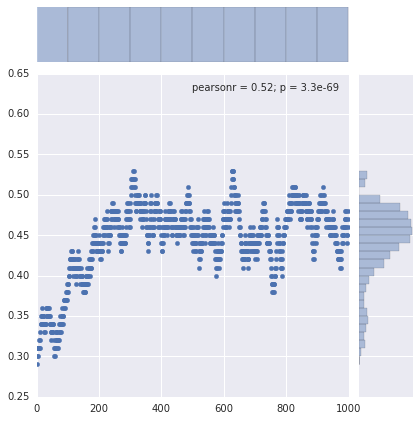

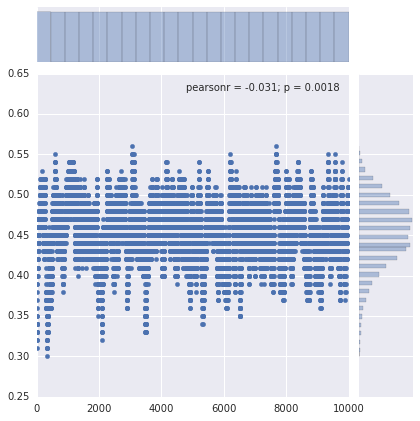

In [7]:
qr = metropolis(100,0.01,0.30,8,data),metropolis(1000,0.01,0.30,8,data),metropolis(10000,0.01,0.30,8,data)

回数を重ねるほど、$q$の値はある定常分布に近づいていく。メトロポリス法などのMCMCアルゴリズムの目的は**特定の値の探索ではなく、ステップ数とともに変化するパラメータの値の生成(サンプリング)。**  
現状では  
* 定常状態に到達するのに必要なサンプリング数が多い。  
* 初期状態に依存する部分がある。  

など定常状態の推定にまだ問題がある。  

* より良いMCMCアルゴリズムを使う
* 初期状態を捨てる  
* 複数のMCMCサンプリングを比較する  

などで改善の余地がある。(第9章以降へ続く)

## 8.4 MCMCサンプリングとベイズ統計モデル

### 定常分布$p(q\mid\mathbf{Y})$の意味  
表記の通り「観測データ$\mathbf{Y}$を得たうえで、$q$という生存確率を得る」確率で、尤度$L(q)$に比例している。すなわち、$p(q\mid\mathbf{Y})=L(q)/\Sigma_q L(q)$  
こうなるためには、
*  $q$が任意の初期値から定常分布に収束する
*  $q_n$が定常分布に従うとき、$q_{n+1}$も定常分布に従う  

であることが必要。とりあえず収束条件は置いておいて、、、(文献を参考とのこと)2つ目をメトロポリス法を例に簡単に証明する。今$q'$が新たに得られたとして、  
$p(q')=\Sigma_q p(q\rightarrow q')*p(q\mid \mathbf{Y})$  
なので、これが定常分布と等しいことを示せば良い。  
ある$q$が得られているとして、試しに$q+dq$を計算する確率は$0.5$。今、$L(q)<L(q+dq)$だとすると$q\rightarrow q+dq$をとなる確率は、  
    $p(q\rightarrow q+dq)=0.5\times 1$.  
逆に$q+dq$を得ている時に$q+dq\rightarrow q$となる確率は、  
    $p(q+dq \rightarrow q) = 0.5\times L(q)/L(q+dq)$  
上2式から、
    $L(q+dq)p(q+dq \rightarrow q) = L(q)p(q\rightarrow q+dq)$
となる。$L(q)>L(q+dq)$の場合も同様。両辺$\Sigma_q L(q)$で割って$q'=q+dq$とし、$q$について和を取れば、(松野注:本に従ったが$q$と$q'$が独立でないので非常に気持ち悪い)  
    $L(q')/\Sigma_q' L(q') \Sigma_q p(q'\rightarrow q) = \Sigma_q p(q\mid\mathbf{Y})p(q\rightarrow q')$  
右辺は$p(q')$に等しく、左辺は$\Sigma_q p(q'\rightarrow q)=1$であるから結局、$q'$も定常分布に従う。  
  
先程の例でも、定常分布が$L(q)$に比例していることが数値的に確かめられる。

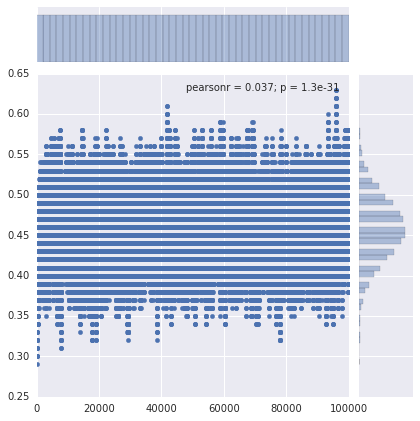

In [8]:
q105=metropolis(10**5,0.01,0.30,8,data)

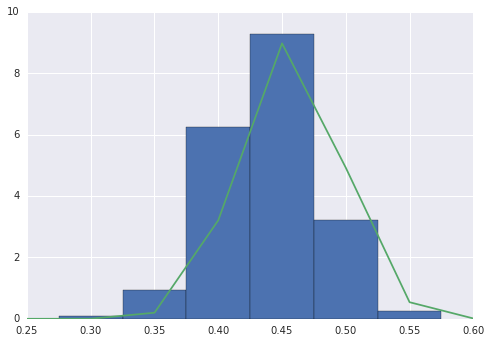

In [10]:
xx = np.arange(0.25,0.65,0.05)
yy = np.zeros(xx.size)
i = 0
from scipy.stats import binom
for xxx in xx:
  yy[i] = np.exp(sum(binom.logpmf(data,nmax,xxx)))
  i = i+1
fig2 = plt.figure()
f2ax1 = fig2.add_subplot(111)
f2ax1.set_xlim(0.25,0.60)
f2ax1.hist(q105,bins=7,range=(0.25,0.6),align='left',normed=True)
f2ax1.plot(xx,yy*2.25e17)

In [15]:
def summary(data):
  minx = min(data)
  stqu = np.percentile(data,25)
  median = np.median(data)
  mean = np.mean(data)
  rdqu = np.percentile(data,75)
  maxx = max(data)
  print("Min.    = {0:.3f} \n1st Qu. = {1:.3f} \nMedian  = {2:.3f} \n"\
          "Mean    = {3:.3f} \n3rd Qu. = {4:.3f} \nMax.    = {5:.3f}"\
          .format(minx,stqu,median,mean,rdqu,maxx))

In [16]:
summary(q105)

Min.    = 0.290 
1st Qu. = 0.430 
Median  = 0.460 
Mean    = 0.459 
3rd Qu. = 0.480 
Max.    = 0.630


### ベイズの公式  
条件付き確率の性質  
$p(q\mid \mathbf{Y}) =\frac{p(\mathbf{Y}\mid q)p(q)}{\Sigma_q p(\mathbf{Y}\mid q)p(q)}$

左辺: 事後分布  
右辺: $\propto $尤度($p(\mathbf{Y}\mid q)\times$事前分布($p(q)$)

事後分布も尤度に比例しているので、事前分布は定数(すなわち$p(q)=$定数). consistent っぽい